In [1]:
import tensorflow as tf
from tensorflow import keras
import math
import numpy as np
import pandas as pd
import matplotlib as mt
import sklearn
import csv
from keras import layers 
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D 
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D 
from keras.models import Model , Sequential
import keras.backend as K
import sklearn
from sklearn.model_selection import train_test_split


In [ ]:
#Model


def placeholder_inputs(batch_size, num_point):
    pointclouds_pl = tf.placeholder(tf.float32,
                                     shape=(batch_size, num_point, 9))
    labels_pl = tf.placeholder(tf.int32,
                                shape=(batch_size, num_point))
    return pointclouds_pl, labels_pl

def get_model(point_cloud, is_training, bn_decay=None):
    """ ConvNet baseline, input is BxNx3 gray image """
    batch_size = point_cloud.get_shape()[0].value
    num_point = point_cloud.get_shape()[1].value

    input_image = tf.expand_dims(point_cloud, -1)
    # CONV
    net = tf_util.conv2d(input_image, 64, [1,9], padding='VALID', stride=[1,1],
                         bn=True, is_training=is_training, scope='conv1', bn_decay=bn_decay)
    net = tf_util.conv2d(net, 64, [1,1], padding='VALID', stride=[1,1],
                         bn=True, is_training=is_training, scope='conv2', bn_decay=bn_decay)
    net = tf_util.conv2d(net, 64, [1,1], padding='VALID', stride=[1,1],
                         bn=True, is_training=is_training, scope='conv3', bn_decay=bn_decay)
    net = tf_util.conv2d(net, 128, [1,1], padding='VALID', stride=[1,1],
                         bn=True, is_training=is_training, scope='conv4', bn_decay=bn_decay)
    points_feat1 = tf_util.conv2d(net, 1024, [1,1], padding='VALID', stride=[1,1],
                         bn=True, is_training=is_training, scope='conv5', bn_decay=bn_decay)
    # MAX
    pc_feat1 = tf_util.max_pool2d(points_feat1, [num_point,1], padding='VALID', scope='maxpool1')
    # FC
    pc_feat1 = tf.reshape(pc_feat1, [batch_size, -1])
    pc_feat1 = tf_util.fully_connected(pc_feat1, 256, bn=True, is_training=is_training, scope='fc1', bn_decay=bn_decay)
    pc_feat1 = tf_util.fully_connected(pc_feat1, 128, bn=True, is_training=is_training, scope='fc2', bn_decay=bn_decay)
    print(pc_feat1)
   
    # CONCAT 
    pc_feat1_expand = tf.tile(tf.reshape(pc_feat1, [batch_size, 1, 1, -1]), [1, num_point, 1, 1])
    points_feat1_concat = tf.concat(axis=3, values=[points_feat1, pc_feat1_expand])
    
    # CONV 
    net = tf_util.conv2d(points_feat1_concat, 512, [1,1], padding='VALID', stride=[1,1],
                         bn=True, is_training=is_training, scope='conv6')
    net = tf_util.conv2d(net, 256, [1,1], padding='VALID', stride=[1,1],
                         bn=True, is_training=is_training, scope='conv7')
    net = tf_util.dropout(net, keep_prob=0.7, is_training=is_training, scope='dp1')
    net = tf_util.conv2d(net, 13, [1,1], padding='VALID', stride=[1,1],
                         activation_fn=None, scope='conv8')
    net = tf.squeeze(net, [2])

    return net

def get_loss(pred, label):
    """ pred: B,N,13
        label: B,N """
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=pred, labels=label)
    return tf.reduce_mean(loss)


    with tf.Graph().as_default():
        with tf.Session() as sess:
            init = tf.global_variables_initializer()
            sess.run(init)
            

In [ ]:
#Train
BATCH_SIZE = 24
NUM_POINT = 4096
MAX_EPOCH = 50
NUM_POINT = num_point
BASE_LEARNING_RATE = 0.001
MOMENTUM = 0.9
OPTIMIZER = 'adam'
DECAY_STEP = 300000
DECAY_RATE = 0.5
MAX_NUM_POINT = 4096
NUM_CLASSES = 13

# Load ALL data
data_batch_list = []
label_batch_list = []
for h5_filename in ALL_FILES:
    data_batch, label_batch = provider.loadDataFile(h5_filename)
    data_batch_list.append(data_batch)
    label_batch_list.append(label_batch)
data_batches = np.concatenate(data_batch_list, 0)
label_batches = np.concatenate(label_batch_list, 0)
print(data_batches.shape)
print(label_batches.shape)


train_data = data_batches[train_idxs,...]
train_label = label_batches[train_idxs]
test_data = data_batches[test_idxs,...]
test_label = label_batches[test_idxs]
print(train_data.shape, train_label.shape)
print(test_data.shape, test_label.shape)


def get_learning_rate(batch):
    learning_rate = tf.train.exponential_decay(
                        BASE_LEARNING_RATE,  # Base learning rate.
                        batch * BATCH_SIZE,  # Current index into the dataset.
                        DECAY_STEP,          # Decay step.
                        DECAY_RATE,          # Decay rate.
                        staircase=True)
    learning_rate = tf.maximum(learning_rate, 0.00001) # CLIP THE LEARNING RATE!!
    return learning_rate        




pointclouds_pl, labels_pl = placeholder_inputs(BATCH_SIZE, NUM_POINT)
            is_training_pl = tf.placeholder(tf.bool, shape=())
            
pred = get_model(pointclouds_pl, is_training_pl, bn_decay=bn_decay)
            loss = get_loss(pred, labels_pl)
            tf.summary.scalar('loss', loss)
            accuracy = tf.reduce_sum(tf.cast(correct, tf.float32)) / float(BATCH_SIZE*NUM_POINT)
            tf.summary.scalar('accuracy', accuracy)
# Init variables
        init = tf.global_variables_initializer()
        sess.run(init, {is_training_pl:True})

        ops = {'pointclouds_pl': pointclouds_pl,
               'labels_pl': labels_pl,
               'is_training_pl': is_training_pl,
               'pred': pred,
               'loss': loss,
               'train_op': train_op,
               'merged': merged,
               'step': batch}

In [ ]:
#Evaluate

pred_data_label_filenames = [line.rstrip() for line in open('all_pred_data_label_filelist.txt')]
gt_label_filenames = [f.rstrip('_pred\.txt') + '_gt.txt' for f in pred_data_label_filenames]
num_room = len(gt_label_filenames)


gt_classes = [0 for _ in range(13)]
positive_classes = [0 for _ in range(13)]
true_positive_classes = [0 for _ in range(13)]
for i in range(num_room):
    print(i)
    data_label = np.loadtxt(pred_data_label_filenames[i])
    pred_label = data_label[:,-1]
    gt_label = np.loadtxt(gt_label_filenames[i])
    print(gt_label.shape)
    for j in xrange(gt_label.shape[0]):
        gt_l = int(gt_label[j])
        pred_l = int(pred_label[j])
        gt_classes[gt_l] += 1
        positive_classes[pred_l] += 1
        true_positive_classes[gt_l] += int(gt_l==pred_l)


print(gt_classes)
print(positive_classes)
print(true_positive_classes)


print('Overall accuracy: {0}'.format(sum(true_positive_classes)/float(sum(positive_classes))))

print 'IoU:'
iou_list = []
for i in range(13):
    iou = true_positive_classes[i]/float(gt_classes[i]+positive_classes[i]-true_positive_classes[i]) 
    print(iou)
    iou_list.append(iou)

print(sum(iou_list)/13.0)


In [ ]:
#trail
X_train.reshape() and X_test.reshape()
to_categorical() 
model.add(Conv2D(64, kernel_size=3, activation=’relu’, input_shape=(28,28,1)))

In [ ]:
#Final outlook
ds = pd.read_csv('dataset.csv')

mydata=np.genfromtxt('dataset.csv',delimiter=',')
x=mydata[:,0:4001]
y=mydata[:,4001]


Y = np.zeros((50,10))
for i in range(50):
    for k in range(9):
        if y[i]==k:
            Y[i,k]=1
        
X=np.zeros((50,4001,1))
X[:,:,0]=x


X_train, X_test, Y_train, Y_test = train_test_split( X, Y, test_size=0.2, random_state=1)

#model
model = Sequential()
n_i = 4001
no_kernels = 1
length_of_kernel = 2001

model.add(Conv1D(no_kernels,length_of_kernel,activation='relu',padding='same',strides=16,input_shape=(n_i,1)))
model.add(MaxPooling1D(3,strides=2,name='max_pool1'))

model.add(Conv1D(1,5,activation='relu',padding='same',strides=4,input_shape=(125,1)))
model.add(MaxPooling1D(3,strides=2,name='max_pool2'))

model.add(Conv1D(1,5,activation='relu',padding='same',strides=2,input_shape=(15,1)))
model.add(MaxPooling1D(2,strides=1,name='max_pool3'))

model.add(Flatten())

model.add(Dense(10,activation='relu'))

model.add(Dense(10,activation='softmax'))

model.compile(loss='mse',optimizer='adam',metrics =['accuracy'] )



model.fit(X_train,Y_train,batch_size=1,epochs=100,verbose=1)
model.evaluate(X_test,Y_test,verbose =0)




In [4]:
import h5py
f = h5py.File('C:\\Users\\Srividya\\Documents\\GitHub\\pointnet\\sem_seg\\indoor3d_sem_seg_hdf5_data\\ply_data_all_22.h5', 'r')
list(f.keys())

['data', 'label']

In [5]:
dset = f['label']
dset

<HDF5 dataset "label": shape (1000, 4096), type "|u1">

In [6]:
kset = f['data']
kset

<HDF5 dataset "data": shape (1000, 4096, 9), type "<f4">

In [8]:
np.dtype(dset)
#dset[584,1000]

dtype('uint8')

In [9]:
kset[1,1,:]

array([0.406     , 0.456     , 0.764     , 0.627451  , 0.65882355,
       0.7019608 , 0.7575653 , 0.9726884 , 0.2628139 ], dtype=float32)

<IPython.core.display.Javascript object>


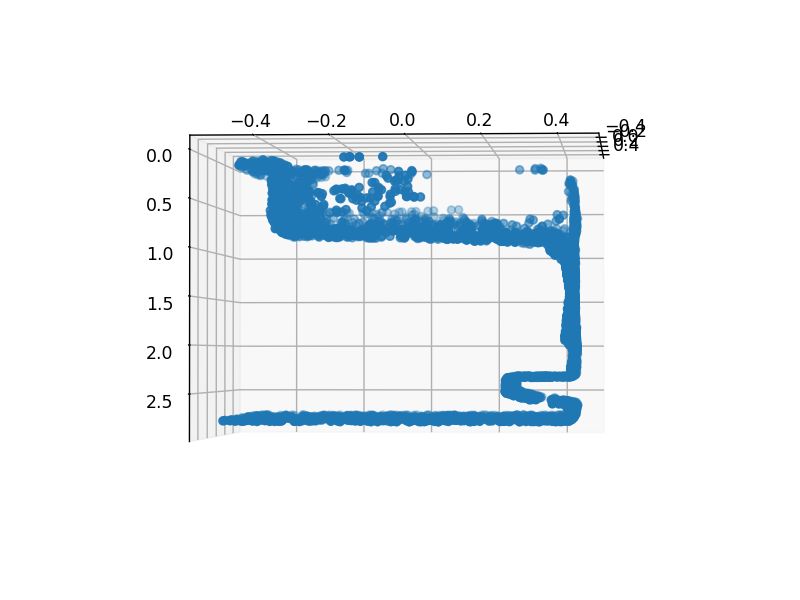

In [10]:
%matplotlib notebook
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = Axes3D(fig)
scatter = ax.scatter(kset[50,:,0] , kset[50,:,1] , kset[50,:,2])

In [2]:
import h5py
def load_h5(h5_filename):
    f = h5py.File(h5_filename)
    data = f['data'][:]
    label = f['label'][:]
    return (data, label)

In [3]:
ALL_FILES = [line.rstrip() for line in open('indoor3d_sem_seg_hdf5_data/all_files.txt')]#provider.getDataFiles('indoor3d_sem_seg_hdf5_data/all_files.txt')
# Load ALL data
data_batch_list = []
label_batch_list = []
for h5_filename in ALL_FILES:
    data_batch, label_batch = load_h5(h5_filename)
    data_batch_list.append(data_batch)
    label_batch_list.append(label_batch)
data_batches = np.concatenate(data_batch_list, 0)
label_batches = np.concatenate(label_batch_list, 0)
print(data_batches.shape)
print(label_batches.shape)


<ipython-input-2-770c02b77a2f>:3: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  f = h5py.File(h5_filename)


(23585, 4096, 9)
(23585, 4096)


In [4]:
# x = data_batches[:,0:4001]
# y = label_batches[:,:]

cat_labels = tf.keras.utils.to_categorical(label_batches, num_classes = 13, dtype = "uint8")
cat_labels[0:2,0:4]
# Y = np.zeros((50,10))
# for i in range(50):
#     for k in range(9):
#         if y[i]==k:
#             Y[i,k]=1
        
# X=np.zeros((50,4001,1))
# X[:,:,0]=x


#X_train, X_test, Y_train, Y_test = train_test_split( data_batches, label_batches_cat , test_size=0.2, random_state=1)


array([[[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],

       [[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]], dtype=uint8)

In [ ]:
# X_train = data_batches[0:10000,:,:]
# X_test =  data_batches[11000:12000,:,:]
# Y_train = cat_labels[0:10000,:,:]
# Y_test =  cat_labels[11000:12000,:,:]

In [5]:
X_train, X_test, Y_train, Y_test = train_test_split( data_batches, cat_labels , test_size=0.2, random_state=1)

In [6]:
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(18868, 4096, 9)
(4717, 4096, 9)
(18868, 4096, 13)
(4717, 4096, 13)


In [8]:
np.shape(cat_labels)[1]

4096

In [ ]:
#Keras Model - Functional API
from tensorflow import keras
batch_size = 24
num_point = 4096
input_image = keras.Input(shape = (4096,9,1))
# def placeholder_inputs(batch_size, num_point):
#     pointclouds_pl = tf.placeholder(tf.float32,
#                                      shape=(batch_size, num_point, 9))
#     labels_pl = tf.placeholder(tf.int32,
#                                 shape=(batch_size, num_point))
#     return pointclouds_pl, labels_pl

#def get_model(point_cloud, is_training, bn_decay=None):
 #   """ ConvNet baseline, input is BxNx3 gray image """
#batch_size= point_cloud.get_shape()[0].value

# BATCH_SIZE = 24
# NUM_POINT = 4096
# MAX_EPOCH = 50
# num_point = 4096
# NUM_POINT = num_point
# BASE_LEARNING_RATE = 0.001
# #MOMENTUM = 0.9
# OPTIMIZER = 'adam'
# #DECAY_STEP = 300000
# #DECAY_RATE = 0.5
# MAX_NUM_POINT = 4096
# NUM_CLASSES = 13
batch_size = 24
num_point = 4096
#batch_size = np.shape(cat_labels)[0]
#num_point = np.shape(cat_labels)[1]
#input_image = tf.expand_dims(X_train, -1)
    # CONV
print(input_image.shape)      
x = Conv2D(64, [1,9], padding='VALID', strides = [1,1], name ='conv1')(input_image)
print(x.shape) 
x = Conv2D(64, [1,1], padding='VALID', strides = [1,1], name ='conv2')(x)
x = Conv2D(64, [1,1], padding='VALID', strides = [1,1], name ='conv3')(x)
x = Conv2D(128, [1,1], padding='VALID', strides = [1,1], name ='conv4')(x)
x= Conv2D(1024, [1,1], padding='VALID', strides = [1,1], name ='conv5')(x)
    # MAX
print(x.shape)    
pc_feat1 = MaxPooling2D([num_point,1], padding='VALID', name ='maxpool1')(x)
print(pc_feat1.shape) 
#from keras import backend as K
#pc_feat1 = model.layers[5].output
#print(pc_feat1)
# inp = model.input                                           # input placeholder
# outputs = [layer.output for layer in model.layers]          # all layer outputs
# functors = [K.function([inp, K.learning_phase()], [out]) for out in outputs]    # evaluation functions
# layer_outs = [func([test, 1.]) for func in functors]
#     # FC
#print(model.summary())
#print(pc_feat1.shape)    
#pc_feat1 = tf.reshape(pc_feat1, [batch_size, -1])
pc_feat1 = Flatten()(pc_feat1)
print(pc_feat1.shape)
#model.add(Flatten())
pc_feat1 = Dense(256, name='fc1')(pc_feat1)
pc_feat1 = Dense(128 , name='fc2')(pc_feat1)
print(pc_feat1.shape)
   
    # CONCAT 
a = tf.keras.layers.Reshape((1,1,-1))(pc_feat1)
print(a.shape)
   
pc_feat1_expand = tf.tile(a, [1,num_point,1,1])
print(pc_feat1_expand.shape)
points_feat1_concat = tf.concat(axis=3, values=[x, pc_feat1_expand])
print(points_feat1_concat.shape)    
    # CONV 

y = Conv2D(512,[1,1], padding='VALID', strides = [1,1], name ='conv6')(points_feat1_concat)
y = Conv2D(256,[1,1], padding='VALID', strides = [1,1],name ='conv7')(y)
    #tf.keras.layers.Dropout(rate, noise_shape=None, seed=None, **kwargs)

y = Dropout(rate = 0.3)(y)
y = Conv2D(13,[1,1],padding='VALID', strides = [1,1],name ='conv8')(y)
net = tf.squeeze(y, [2])

    #return net
model = keras.Model(inputs = input_image, outputs = net)
model.compile(loss = 'categorical_crossentropy',optimizer='adam',metrics =['accuracy'] )
#loss = keras.losses.SparseCategoricalCrossentropy(from_logits = True)

model.fit(X_train,Y_train,batch_size=24,epochs=3,verbose=2)
model.evaluate(X_test,Y_test,verbose = 2)
                

# from keras import backend as K

# inp = model.input                                           # input placeholder
# outputs = [layer.output for layer in model.layers]          # all layer outputs
# functors = [K.function([inp, K.learning_phase()], [out]) for out in outputs]    # evaluation functions

# # Testing
# test = np.random.random(input_shape)[np.newaxis,...]
# layer_outs = [func([test, 1.]) for func in functors]
# print layer_outs
    
    #def get_loss(pred, label):
#    """ pred: B,N,13
#       label: B,N """
#    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=pred, labels=label)
#    return tf.reduce_mean(loss)


#    with tf.Graph().as_default():
#        with tf.Session() as sess:
#            init = tf.global_variables_initializer()
#            sess.run(init)
            

(None, 4096, 9, 1)
(None, 4096, 1, 64)
(None, 4096, 1, 1024)
(None, 1, 1, 1024)
(None, 1024)
(None, 128)
(None, 1, 1, 128)
(None, 4096, 1, 128)
(None, 4096, 1, 1152)
Epoch 1/3


In [ ]:
#Tensorflow model
import tensorflow as tf
import math
import time
import numpy as np
import os
import sys


def placeholder_inputs(batch_size, num_point):
    pointclouds_pl = tf.placeholder(tf.float32,
                                     shape=(batch_size, num_point, 9))
    labels_pl = tf.placeholder(tf.int32,
                                shape=(batch_size, num_point))
    return pointclouds_pl, labels_pl

def get_model(point_cloud, is_training, bn_decay=None):
    """ ConvNet baseline, input is BxNx3 gray image """
    batch_size = point_cloud.get_shape()[0].value
    num_point = point_cloud.get_shape()[1].value

    input_image = tf.expand_dims(point_cloud, -1)
    # CONV
    net = tf.nn.conv2d(input_image, 64, [1,9], padding='VALID', stride=[1,1],
                         scope='conv1')
    net = tf.nn.conv2d(net, 64, [1,1], padding='VALID', stride=[1,1],
                         scope='conv2')
    net = tf.nn.conv2d(net, 64, [1,1], padding='VALID', stride=[1,1],
                         scope='conv3')
    net = tf.nn.conv2d(net, 128, [1,1], padding='VALID', stride=[1,1],
                         scope='conv4')
    points_feat1 = tf.nn.conv2d(net, 1024, [1,1], padding='VALID', stride=[1,1],
                          scope='conv5')
    # MAX
    pc_feat1 = tf.nn.max_pool2d(points_feat1, [num_point,1], padding='VALID', scope='maxpool1')
    # FC
    pc_feat1 = tf.reshape(pc_feat1, [batch_size, -1])
    pc_feat1 = tf.nn.relu(pc_feat1, 256, scope='fc1')
    pc_feat1 = tf.nn.relu(pc_feat1, 128, scope='fc2')
    print(pc_feat1)
   
    # CONCAT 
    pc_feat1_expand = tf.tile(tf.reshape(pc_feat1, [batch_size, 1, 1, -1]), [1, num_point, 1, 1])
    points_feat1_concat = tf.concat(axis=3, values=[points_feat1, pc_feat1_expand])
    
    # CONV 
    net = tf.nn.conv2d(points_feat1_concat, 512, [1,1], padding='VALID', stride=[1,1],
                         scope='conv6')
    net = tf.nn.conv2d(net, 256, [1,1], padding='VALID', stride=[1,1],
                         scope='conv7')
    #net = tf_util.dropout(net, keep_prob=0.7, is_training=is_training, scope='dp1')
    net = tf.nn.conv2d(net, 13, [1,1], padding='VALID', stride=[1,1],
                         activation_fn=None, scope='conv8')
    net = tf.squeeze(net, [2])

    return net

def get_loss(pred, label):
    """ pred: B,N,13
        label: B,N """
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=pred, labels=label)
    return tf.reduce_mean(loss)

if __name__ == "__main__":
    with tf.Graph().as_default():
        a = tf.placeholder(tf.float32, shape=(32,4096,9))
        net = get_model(a, tf.constant(True))
        with tf.Session() as sess:
            init = tf.global_variables_initializer()
            sess.run(init)
            start = time.time()
            for i in range(100):
                print(i)
                sess.run(net, feed_dict={a:np.random.rand(32,4096,9)})
            print(time.time() - start)

In [ ]:

pred_data_label_filenames = [line.rstrip() for line in open('all_pred_data_label_filelist.txt')]
gt_label_filenames = [f.rstrip('_pred\.txt') + '_gt.txt' for f in pred_data_label_filenames]
num_room = len(gt_label_filenames)


gt_classes = [0 for _ in range(13)]
positive_classes = [0 for _ in range(13)]
true_positive_classes = [0 for _ in range(13)]
for i in range(num_room):
    print(i)
    data_label = np.loadtxt(pred_data_label_filenames[i])
    pred_label = data_label[:,-1]
    gt_label = np.loadtxt(gt_label_filenames[i])
    print(gt_label.shape)
    for j in xrange(gt_label.shape[0]):
        gt_l = int(gt_label[j])
        pred_l = int(pred_label[j])
        gt_classes[gt_l] += 1
        positive_classes[pred_l] += 1
        true_positive_classes[gt_l] += int(gt_l==pred_l)


print(gt_classes)
print(positive_classes)
print(true_positive_classes)


print('Overall accuracy: {0}'.format(sum(true_positive_classes)/float(sum(positive_classes))))

print 'IoU:'
iou_list = []
for i in range(13):
    iou = true_positive_classes[i]/float(gt_classes[i]+positive_classes[i]-true_positive_classes[i]) 
    print(iou)
    iou_list.append(iou)

print(sum(iou_list)/13.0)
